In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import pytesseract as pt
import plotly.express as px
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet

from glob import glob
from skimage import io
from shutil import copy
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

The coordinates of the bounding boxes are stored in .xml files, so we first have to parse them and get the *xmin*, *xmax*, *ymin*, *ymax* points. Below, I will first store them in a dictionary along with their filenames then convert them into a dataframe.

In [2]:
path = glob("../input/number-plate-detection/images/*.xml")
labels_dict = dict(filepath=[],xmin=[],xmax=[],ymin=[],ymax=[])
for filename in path:

    info = xet.parse(filename)
    root = info.getroot()
    member_object = root.find("object")
    labels_info = member_object.find("bndbox")
    xmin = int(labels_info.find("xmin").text)
    xmax = int(labels_info.find("xmax").text)
    ymin = int(labels_info.find("ymin").text)
    ymax = int(labels_info.find("ymax").text)

    labels_dict["filepath"].append(filename)
    labels_dict["xmin"].append(xmin)
    labels_dict["xmax"].append(xmax)
    labels_dict["ymin"].append(ymin)
    labels_dict["ymax"].append(ymax)

In [3]:
df = pd.DataFrame(labels_dict)
df.to_csv("labels.csv",index=False)
df.head()

filepath  xmin  xmax  ymin  ymax
0  ../input/number-plate-detection/images/N148.xml   244   369   240   293
1  ../input/number-plate-detection/images/N177.xml   331   538   263   317
2  ../input/number-plate-detection/images/N173.xml    80   335   150   243
3  ../input/number-plate-detection/images/N213.xml   131   209   129   153
4  ../input/number-plate-detection/images/N119.xml   180   559   216   314

In [4]:
filename = df["filepath"][0]
def getFilename(filename):
    filename_image = xet.parse(filename).getroot().find("filename").text
    filepath_image = os.path.join("../input/number-plate-detection/images",filename_image)
    return filepath_image
getFilename(filename)

'../input/number-plate-detection/images/N148.jpeg'

In [5]:
image_path = list(df["filepath"].apply(getFilename))
image_path[:10]

['../input/number-plate-detection/images/N148.jpeg',
 '../input/number-plate-detection/images/N177.jpeg',
 '../input/number-plate-detection/images/N173.jpeg',
 '../input/number-plate-detection/images/N213.jpeg',
 '../input/number-plate-detection/images/N119.jpeg',
 '../input/number-plate-detection/images/N103.jpeg',
 '../input/number-plate-detection/images/N166.jpeg',
 '../input/number-plate-detection/images/N127.jpeg',
 '../input/number-plate-detection/images/N162.jpeg',
 '../input/number-plate-detection/images/N198.jpeg']

In [6]:
file_path = image_path[71] 
img = cv2.imread(file_path)
img = io.imread(file_path) #converting image into array
fig = px.imshow(img)
fig.update_layout(width=600, height=500, margin=dict(l=10, r=10, b=10, t=10))
fig.add_shape(type="rect",x0=71, x1=200, y0=231, y1=290, xref="x", yref="y",line_color="cyan")

In [7]:
labels = df.iloc[:,1:].values
data = []
output = []

for ind in range(len(image_path)):
    image = image_path[ind]
    img_arr = cv2.imread(image)
    h,w,d = img_arr.shape
    load_image = load_img(image,target_size=(224,224))
    load_image_arr = img_to_array(load_image)
    
    # normalization
    norm_load_image_arr = load_image_arr/255.0 
    xmin,xmax,ymin,ymax = labels[ind]
    nxmin,nxmax = xmin/w,xmax/w
    nymin,nymax = ymin/h,ymax/h
    label_norm = (nxmin,nxmax,nymin,nymax)
    
    data.append(norm_load_image_arr)
    output.append(label_norm)

In [8]:
# Converting all images to array
X = np.array(data,dtype=np.float32)
y = np.array(output,dtype=np.float32)

In [9]:
print(X[0])

[[[0.24313726 0.29411766 0.3254902 ]
  [0.23529412 0.3019608  0.32941177]
  [0.23921569 0.3137255  0.3372549 ]
  ...
  [0.1882353  0.23529412 0.23529412]
  [0.3254902  0.37254903 0.37254903]
  [0.15294118 0.19215687 0.2       ]]

 [[0.2509804  0.3019608  0.33333334]
  [0.31764707 0.38431373 0.4117647 ]
  [0.3372549  0.40392157 0.43137255]
  ...
  [0.23529412 0.28235295 0.27450982]
  [0.22745098 0.27450982 0.26666668]
  [0.17254902 0.21176471 0.21568628]]

 [[0.28235295 0.34117648 0.36862746]
  [0.3137255  0.38039216 0.40784314]
  [0.32156864 0.3882353  0.41568628]
  ...
  [0.23921569 0.28627452 0.27058825]
  [0.28627452 0.33333334 0.31764707]
  [0.19607843 0.23529412 0.23137255]]

 ...

 [[0.49803922 0.14117648 0.16862746]
  [0.5137255  0.1254902  0.13725491]
  [0.5058824  0.09411765 0.10980392]
  ...
  [0.74509805 0.40784314 0.41960785]
  [0.72156864 0.54901963 0.5372549 ]
  [0.6039216  0.58431375 0.5686275 ]]

 [[0.5019608  0.15294118 0.1764706 ]
  [0.5176471  0.12941177 0.14901961]


In [10]:
print(y[0])

[0.40666667 0.615      0.55813956 0.68139535]


Now, after all data pre-processing, it"s time to train our model.

In [11]:
# Spliting the data into train and test set.
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=0)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((180, 224, 224, 3), (45, 224, 224, 3), (180, 4), (45, 4))

InceptionResNetv2 

In [12]:
inception_resnet = InceptionResNetV2(weights="imagenet",include_top=False, input_tensor=Input(shape=(224,224,3)))
headmodel = inception_resnet.output
headmodel = Flatten()(headmodel)
headmodel = Dense(500,activation="relu")(headmodel)
headmodel = Dense(250,activation="relu")(headmodel)
headmodel = Dense(4,activation="sigmoid")(headmodel)

model = Model(inputs=inception_resnet.input,outputs=headmodel)

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
model.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 73,663,490 (281.00 MB)

 Trainable params: 73,602,946 (280.77 MB)

 Non-trainable params: 60,544 (236.50 KB)

In [14]:
tfb = TensorBoard("object_detection")
history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=10,
                    epochs=180,
                    validation_data=(X_test,y_test),
                    callbacks=[tfb])

Epoch 1/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 156s 1s/step - loss: 0.0608 - val_loss: 0.0301
Epoch 2/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0163 - val_loss: 0.0170
Epoch 3/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0067 - val_loss: 0.0114
Epoch 4/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0048 - val_loss: 0.0135
Epoch 5/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0044 - val_loss: 0.0092
Epoch 6/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0051 - val_loss: 0.0079
Epoch 7/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0044 - val_loss: 0.0086
Epoch 8/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0036 - val_loss: 0.0077
Epoch 9/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0026 - val_loss: 0.0072
Epoch 10/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0023 - val_loss: 0.0086
Epoch 11/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 168ms/step - loss: 0.0019 - val_loss: 0.0069
Epoch 12/180
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s

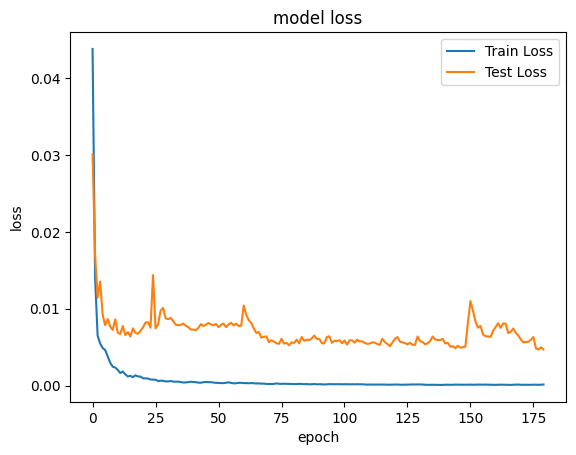

In [15]:
# summarize history for loss
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["Train Loss", "Test Loss"], loc="upper right")
plt.show()

In [16]:
model.save("./my_model.keras")

In [17]:
# for tensorboard uncomment the code below
# !tensorboard --logdir="../working/object_detection.h5"

In [18]:
path = "../input/number-plate-detection/TEST/TEST.jpeg"
image = load_img(path) # PIL object
image = np.array(image,dtype=np.uint8) # 8 bit array (0,255)
image1 = load_img(path,target_size=(224,224))
image_arr_224 = img_to_array(image1)/255.0  # convert into array and get the normalized output

# Size of the orginal image
h,w,d = image.shape
print("Height of the image =",h)
print("Width of the image =",w)

Height of the image = 729
Width of the image = 901


In [19]:
fig = px.imshow(image)
fig.update_layout(width=700, height=500,  margin=dict(l=10, r=10, b=10, t=10), xaxis_title="TEST Image")

In [20]:
image_arr_224.shape

(224, 224, 3)

In [21]:
test_arr = image_arr_224.reshape(1,224,224,3)
test_arr.shape

(1, 224, 224, 3)

You can also load the saved model by running the below code but as the model is already trained so I will simply comment it for now. 

In [22]:
# model = tf.keras.models.load_model('my_model.keras')

In [23]:
# make predictions
coords = model.predict(test_arr)
coords

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


array([[0.37166077, 0.64146   , 0.6523966 , 0.7364718 ]], dtype=float32)

In [24]:
# denormalize the values
denorm = np.array([w,w,h,h])
coords = coords * denorm
coords

array([[334.86635286, 577.95546132, 475.59713548, 536.88792193]])

In [25]:
coords = coords.astype(np.int32)
coords

array([[334, 577, 475, 536]], dtype=int32)

In [26]:
# draw bounding on top of the image
xmin, xmax,ymin,ymax = coords[0]
pt1 =(xmin,ymin)
pt2 =(xmax,ymax)
print(pt1, pt2)

(334, 475) (577, 536)


In [27]:
cv2.rectangle(image, pt1, pt2, (0, 255, 0), 3)
fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l = 10, r = 10, b = 10, t = 10))

Creating pipeline

In [28]:
path = "../input/number-plate-detection/TEST/TEST.jpeg"
def object_detection(path):
    
    # read image
    image = load_img(path) # PIL object
    image = np.array(image,dtype=np.uint8)
    image1 = load_img(path,target_size=(224,224))
    
    # data preprocessing
    image_arr_224 = img_to_array(image1)/255.0 # convert image to array & normalize it
    h,w,d = image.shape
    test_arr = image_arr_224.reshape(1,224,224,3)
    
    # make predictions
    coords = model.predict(test_arr)
    
    # denormalize the values
    denorm = np.array([w,w,h,h])
    coords = coords * denorm
    coords = coords.astype(np.int32)
    
    # draw bounding box on top of the image
    xmin, xmax,ymin,ymax = coords[0]
    pt1 =(xmin,ymin)
    pt2 =(xmax,ymax)
    print(pt1, pt2)
    cv2.rectangle(image,pt1,pt2,(0,255,0),3)
    return image, coords

image, cods = object_detection(path)

fig = px.imshow(image)
fig.update_layout(width=700, height=500, margin=dict(l=10, r=10, b=10, t=10),xaxis_title="TEST IMAGE")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
(334, 475) (577, 536)


Till now I have trained the model and got the coordinates for number plate. Now, with the help of these predicted coodinates, I will identify the region of interest(ROI) which in this case will be license number plate and and then pass the ROI to Python-tesseract which is an optical character recognition (OCR) tool for python. 

In [29]:
img = np.array(load_img(path))
xmin ,xmax,ymin,ymax = cods[0]
roi = img[ymin:ymax,xmin:xmax]
fig = px.imshow(roi)
fig.update_layout(width=350, height=250, margin=dict(l=10, r=10, b=10, t=10),xaxis_title="NUMBER PLATE")

In [30]:
# extract text from image with the help of pytesseract
text = pt.image_to_string(roi)
print(text)

KL 51 K 4999



Now, this model has not very good precision in detecting the license plate and also it is very, slow processing. So for overcoming this problem, I will use You only look once (YOLO) v5 model. With YOLO, we can also recognize the number plates in real time with fast processing.

YOLO

For YOLO model we have to pass some extra information to model which will include the center of bouding boxes.

In [31]:
# parsing
def parsing(path):
    parser = xet.parse(path).getroot()
    name = parser.find("filename").text
    filename = f"../input/number-plate-detection/images/{name}"

    # width and height
    parser_size = parser.find("size")
    width = int(parser_size.find("width").text)
    height = int(parser_size.find("height").text)
    
    return filename, width, height
df[["filename","width","height"]] = df["filepath"].apply(parsing).apply(pd.Series)
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ../input/number-plate-detection/images/N148.xml   244   369   240   293   
1  ../input/number-plate-detection/images/N177.xml   331   538   263   317   
2  ../input/number-plate-detection/images/N173.xml    80   335   150   243   
3  ../input/number-plate-detection/images/N213.xml   131   209   129   153   
4  ../input/number-plate-detection/images/N119.xml   180   559   216   314   

                                           filename  width  height  
0  ../input/number-plate-detection/images/N148.jpeg    600     430  
1  ../input/number-plate-detection/images/N177.jpeg    850     681  
2  ../input/number-plate-detection/images/N173.jpeg    445     349  
3  ../input/number-plate-detection/images/N213.jpeg    350     196  
4  ../input/number-plate-detection/images/N119.jpeg    678     475

In [32]:
# center_x, center_y, width , height
df["center_x"] = (df["xmax"] + df["xmin"]) / (2*df["width"])
df["center_y"] = (df["ymax"] + df["ymin"]) / (2*df["height"])

df["bb_width"] = (df["xmax"] - df["xmin"]) / df["width"]
df["bb_height"] = (df["ymax"] - df["ymin"]) / df["height"]
df.head()

filepath  xmin  xmax  ymin  ymax  \
0  ../input/number-plate-detection/images/N148.xml   244   369   240   293   
1  ../input/number-plate-detection/images/N177.xml   331   538   263   317   
2  ../input/number-plate-detection/images/N173.xml    80   335   150   243   
3  ../input/number-plate-detection/images/N213.xml   131   209   129   153   
4  ../input/number-plate-detection/images/N119.xml   180   559   216   314   

                                           filename  width  height  center_x  \
0  ../input/number-plate-detection/images/N148.jpeg    600     430  0.510833   
1  ../input/number-plate-detection/images/N177.jpeg    850     681  0.511176   
2  ../input/number-plate-detection/images/N173.jpeg    445     349  0.466292   
3  ../input/number-plate-detection/images/N213.jpeg    350     196  0.485714   
4  ../input/number-plate-detection/images/N119.jpeg    678     475  0.544985   

   center_y  bb_width  bb_height  
0  0.619767  0.208333   0.123256  
1  0.425844  0.243529   0.079295  
2  0.563037  0.573034   0.266476  
3  0.719388  0.222857   0.122449  
4  0.557895  0.558997   0.206316

Now it's time to train the YOLO model.

In [33]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...


/usr/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



remote: Enumerating objects: 17120, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 17120 (delta 35), reused 16 (delta 12), pack-reused 17056 (from 3)
Receiving objects: 100% (17120/17120), 15.79 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (11742/11742), done.


In [34]:
!pip install -r ./yolov5/requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.8/906.8 kB 15.5 MB/s eta 0:00:00a 0:00:01


In [35]:
mkdir /kaggle/working/yolov5/data_images/

In [36]:
mkdir /kaggle/working/yolov5/data_images/test/

In [37]:
mkdir /kaggle/working/yolov5/data_images/train/

In [38]:
### split the data into train and test
df_train = df.iloc[:200]
df_test = df.iloc[200:]

In [39]:
train_folder = "./yolov5/data_images/train"

values = df_train[["filename", "center_x", "center_y", "bb_width", "bb_height"]].values
for fname, x, y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(train_folder, image_name)
    dst_label_file = os.path.join(train_folder, txt_name + ".txt")
    
    # copy each image into the folder
    copy(fname, dst_image_path)

    # generate .txt which has label info
    label_txt = f"0 {x} {y} {w} {h}"
    with open(dst_label_file,mode="w") as f:
        f.write(label_txt)
        
        f.close()

test_folder = "./yolov5/data_images/test"

values = df_test[["filename", "center_x", "center_y", "bb_width", "bb_height"]].values
for fname, x, y, w, h in values:
    image_name = os.path.split(fname)[-1]
    txt_name = os.path.splitext(image_name)[0]
    
    dst_image_path = os.path.join(test_folder, image_name)
    dst_label_file = os.path.join(test_folder, txt_name + ".txt")
    
    # copy each image into the folder
    copy(fname,dst_image_path)

    # generate .txt which has label info
    label_txt = f"0 {x} {y} {w} {h}"
    with open(dst_label_file,mode="w") as f:
        f.write(label_txt)
        f.close()

Below code will help to clear cache memory in GPU.

In [40]:
!pip install GPUtil

import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache() 

/usr/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



  Preparing metadata (setup.py) ... done
  Created wheel for GPUtil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=d6b0469b35a277b19677f203ae484fc3c93e962ae104d48fae5e401e09a1ac1f
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built GPUtil
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% | 97% |
GPU Usage after emptying the cache
| ID | GPU  | MEM |
-------------------
|  0 | 100% |  2% |


In [41]:
!python ./yolov5/train.py --data ../input/number-plate-detection/data.yaml --cfg ./yolov5/models/yolov5s.yaml --batch-size 8 --name Model --epochs 100

/usr/lib/python3.10/pty.py:89: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-12 16:09:12.653464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-12 16:09:12.676601: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-12 16:09:12.683081: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

In [42]:
!python ./yolov5/export.py --weight ./yolov5/runs/train/Model/weights/best.pt --include torchscript onnx

export: data=yolov5/data/coco128.yaml, weights=['./yolov5/runs/train/Model/weights/best.pt'], imgsz=[640, 640], batch_size=1, device=cpu, half=False, inplace=False, keras=False, optimize=False, int8=False, per_tensor=False, dynamic=False, cache=, simplify=False, mlmodel=False, opset=17, verbose=False, workspace=4, nms=False, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.25, include=['torchscript', 'onnx']
YOLOv5 🚀 v7.0-394-g86fd1ab2 Python-3.10.12 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

PyTorch: starting from yolov5/runs/train/Model/weights/best.pt with output shape (1, 25200, 6) (13.8 MB)

TorchScript: starting export with torch 2.4.1+cu121...
TorchScript: export success ✅ 1.9s, saved as yolov5/runs/train/Model/weights/best.torchscript (27.2 MB)

ONNX: starting export with onnx 1.17.0...
ONNX: export success ✅ 0.8s, saved as yolov5/runs/train/Model/weights/best.onnx (27.2 M

In [43]:
INPUT_WIDTH =  640
INPUT_HEIGHT = 640

In [44]:
# again loading the test image
img = io.imread("../input/number-plate-detection/TEST/TEST.jpeg")
fig = px.imshow(img)
fig.update_layout(width=700, height=400, margin=dict(l=10, r=10, b=10, t=10))
fig.update_xaxes(showticklabels=False).update_yaxes(showticklabels=False)
fig.show()

In [45]:
# loading out YOLO model
net = cv2.dnn.readNetFromONNX("../working/yolov5/runs/train/Model/weights/best.onnx")
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In the function bellow I parsed the image to my YOLO model to get the prediction.

In [46]:
def get_detections(img,net):
    
    # convert image to YOLO format
    image = img.copy()
    row, col, d = image.shape
    max_rc = max(row,col)
    input_image = np.zeros((max_rc, max_rc,3),dtype = np.uint8)
    input_image[0:row, 0:col] = image

    # get prediction from YOLO model
    blob = cv2.dnn.blobFromImage(input_image,1 / 255,(INPUT_WIDTH,INPUT_HEIGHT), swapRB = True, crop = False)
    net.setInput(blob)
    preds = net.forward()
    detections = preds[0]
    
    return input_image, detections

In the below function, I will filter detections based on the confidence and probability score.

In [47]:
def non_maximum_supression(input_image,detections):
    boxes = []
    confidences = []
    image_w, image_h = input_image.shape[:2]
    x_factor = image_w/INPUT_WIDTH
    y_factor = image_h/INPUT_HEIGHT

    for i in range(len(detections)):
        row = detections[i]
        # confidence score
        confidence = row[4]
        if confidence > 0.4:
            # probability score 
            class_score = row[5] 
            if class_score > 0.25:
                cx, cy , w, h = row[0:4]

                left = int((cx - 0.5*w)*x_factor)
                top = int((cy-0.5*h)*y_factor)
                width = int(w*x_factor)
                height = int(h*y_factor)
                box = np.array([left,top,width,height])
                
                confidences.append(confidence)
                boxes.append(box)

    boxes_np = np.array(boxes).tolist()
    confidences_np = np.array(confidences).tolist()
    index = cv2.dnn.NMSBoxes(boxes_np,confidences_np,0.25,0.45)
    
    return boxes_np, confidences_np, index

In [48]:
# for returning the image with bounding box
def drawings(image,boxes_np,confidences_np,index):
    for ind in index:
        x,y,w,h =  boxes_np[ind]
        bb_conf = confidences_np[ind]
        conf_text = 'plate: {:.0f}%'.format(bb_conf*100)
        license_text = extract_text(image,boxes_np[ind])


        cv2.rectangle(image,(x,y),(x + w, y + h), (255, 0, 255), 2)
        cv2.rectangle(image, (x, y - 30), (x + w, y),(255, 0, 255), -1)
        cv2.rectangle(image, (x, y + h), (x + w, y + h + 25), (0, 0, 0), -1)


        cv2.putText(image,conf_text,(x, y - 10),cv2.FONT_HERSHEY_SIMPLEX,0.7, (255, 255, 255), 1)
        cv2.putText(image,license_text,(x, y + h+ 27),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 1)

    return image

Now, combine all the above functions.

In [49]:
def yolo_predictions(img, net):
    input_image, detections = get_detections(img, net)
    boxes_np, confidences_np, index = non_maximum_supression(input_image, detections)
    result_img = drawings(img,boxes_np,confidences_np,  index)
    return result_img

In [50]:
# extrating text
def extract_text(image,bbox):
    x,y,w,h = bbox
    roi = image[y:y+h, x:x+w]
    
    if 0 in roi.shape:
        return "no number"
    
    else:
        text = pt.image_to_string(roi)
        text = text.strip()
        
        return text

In [51]:
# test
img = io.imread("../input/number-plate-detection/TEST/TEST.jpeg")
results = yolo_predictions(img, net)

In [52]:
fig = px.imshow(img)
fig.update_layout(width = 700, height = 400, margin = dict(l = 10, r = 10, b = 10, t = 10))
fig.update_xaxes(showticklabels = False).update_yaxes(showticklabels = False)
fig.show()